In [1]:
import numpy as np
import scipy as sc 
import pandas as pd 
from scipy.integrate import quad
from scipy.spatial.distance import squareform
from numpy import random
import networkx as nx
import pickle

from data_load import load_meshes_coor_tria, load_data

import os
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit


import matplotlib.pyplot as plt
%matplotlib inline

path_data  = '/cobrain/groups/ml_group/data/HCP/HCP/'
connec , thinkness, log_jac, unique_labels, labels, mean_area_eq, idx_subj_connec = load_data(path_data)
path_tria = '/cobrain/groups/ml_group/data/HCP/HCP/'
name = "_200_mean_IC5.m"
coord, tria = load_meshes_coor_tria(path_tria, name)

Connectomes:  (789, 2, 68, 68)
Thinkness:  (789, 2, 163842)
Log Jacob:  (789, 2, 163842)
Unique Labels:  (789, 2, 163842)
Mean Labels:  (2, 163842)
Mean Area eq:  (2, 163842)
Meshes coordinates shape:  (20484, 3)
Number of triangles of meshes:  (40960, 3)


In [2]:
# with open(path_data + "not_normed_connectomes", 'rb') as f:
#     Y = pickle.load(f)
Y = connec[:,0,:,:]


In [57]:
mesh_areaarea.shape

(789, 327684)

In [56]:
mesh_area = mean_area_eq * np.exp(log_jac)
mesh_area.shape

ValueError: operands could not be broadcast together with shapes (2,163842) (789,327684) 

In [4]:
m = len(coord)//2
new_thickness = np.concatenate([thinkness[:,0,:m], thinkness[:,1,:m]], axis = -1)

new_log_jac = np.concatenate([log_jac[:,0,:m], log_jac[:,1,:m]], axis = -1)

new_mesh_area = np.concatenate([mesh_area[:,0,:m], mesh_area[:,1,:m]], axis = -1)

new_labels = np.concatenate([labels[0,:m], labels[1,:m]])
new_thickness.shape, new_log_jac.shape, new_mesh_area.shape, new_labels.shape

((789, 20484), (789, 20484), (789, 20484), (20484,))

In [6]:
thinkness = thinkness.reshape(789,-1)
log_jac = log_jac.reshape(789,-1)
mesh_area = mesh_area.reshape(789,-1)
labels = labels.reshape(-1)
idx = np.where(labels != 0)[0]
X1 = thinkness[:,idx]
X2 = log_jac[:,idx] 
X3 = mesh_area[:,idx]

In [7]:
new_idx = np.where(new_labels != 0)[0]
new_X1 = new_thickness[:,new_idx]
new_X2 = new_log_jac[:,new_idx] 
new_X3 = new_mesh_area[:,new_idx]

In [28]:
def eigvals(Y):
    T = np.array([np.diag(y.sum(axis = -1)) - y for y in Y])
    E = np.array([sorted(np.linalg.eigvals(t))[1:] for t in T])
    return np.real(E)

In [29]:
Y.shape

(789, 68, 68)

In [30]:
Eig = eigvals(Y)

In [31]:
Eig.shape

(789, 67)

In [32]:
lin_reg = ElasticNet()
ss = ShuffleSplit(n_splits=3, test_size=0.2)

In [13]:
new_X1.shape

(789, 18904)

In [14]:
r2_train = []
r2_test = []
for train_idx, test_idx in ss.split(new_X1):
    X_train, y_train = new_X1[train_idx], Eig[train_idx]
    X_test, y_test = new_X1[test_idx], Eig[test_idx]
    
    lin_reg.fit(X_train, y_train)
    
    r2_train += [r2_score(y_train, lin_reg.predict(X_train))]
    
    r2_test += [r2_score(y_test, lin_reg.predict(X_test))]
    
    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                          mean_squared_error(y_test, lin_reg.predict(X_test))))
    
    print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))
    

print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))

/home/ayagoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


MSE train: 4088347.25, test: 90140032.0
R2 train: 0.9699950752001212, test: 0.23745349419833975
MSE train: 3961609.0, test: 117680896.0
R2 train: 0.9684965423166003, test: 0.28576025645768705
MSE train: 4073120.0, test: 98592224.0
R2 train: 0.9699506999659283, test: 0.2024700402369093
R2 train: 0.9699506999659283, test: 0.24189459696431204


In [16]:
r2_train = []
r2_test = []
for train_idx, test_idx in ss.split(new_X1):
    X_train, y_train = new_X2[train_idx], Eig[train_idx]
    X_test, y_test = new_X2[test_idx], Eig[test_idx]
    
    lin_reg.fit(X_train, y_train)
    
    r2_train += [r2_score(y_train, lin_reg.predict(X_train))]
    
    r2_test += [r2_score(y_test, lin_reg.predict(X_test))]
    
    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                          mean_squared_error(y_test, lin_reg.predict(X_test))))
    
    print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))
    

print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))

MSE train: 7293528.5, test: 99265528.0
R2 train: 0.9430869071100306, test: 0.3241509214554881
MSE train: 7504567.5, test: 92359464.0
R2 train: 0.9436166750338302, test: 0.2699628421613184
MSE train: 7257443.5, test: 104842960.0
R2 train: 0.943354483148042, test: 0.28304069232007667
R2 train: 0.943354483148042, test: 0.2923848186456277


In [15]:
r2_train = []
r2_test = []
for train_idx, test_idx in ss.split(new_X1):
    X_train, y_train = new_X3[train_idx], Eig[train_idx]
    X_test, y_test = new_X3[test_idx], Eig[test_idx]
    
    lin_reg.fit(X_train, y_train)
    
    r2_train += [r2_score(y_train, lin_reg.predict(X_train))]
    
    r2_test += [r2_score(y_test, lin_reg.predict(X_test))]
    
    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                          mean_squared_error(y_test, lin_reg.predict(X_test))))
    
    print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))
    

print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))

MSE train: 53939800.0, test: 78582336.0
R2 train: 0.6002499177247717, test: 0.3872080518820403
MSE train: 53341312.0, test: 79668832.0
R2 train: 0.6093381833622835, test: 0.35328125940983485
MSE train: 50516356.0, test: 98626360.0
R2 train: 0.6138544683475099, test: 0.3119384659191309
R2 train: 0.6138544683475099, test: 0.35080925907033533


In [17]:
new_X4 = new_mesh_area *np.exp(new_log_jac)

In [18]:
r2_train = []
r2_test = []
for train_idx, test_idx in ss.split(new_X1):
    X_train, y_train = new_X4[train_idx], Eig[train_idx]
    X_test, y_test = new_X4[test_idx], Eig[test_idx]
    
    lin_reg.fit(X_train, y_train)
    
    r2_train += [r2_score(y_train, lin_reg.predict(X_train))]
    
    r2_test += [r2_score(y_test, lin_reg.predict(X_test))]
    
    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                          mean_squared_error(y_test, lin_reg.predict(X_test))))
    
    print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))
    

print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))

MSE train: 18879256.0, test: 73399304.0
R2 train: 0.8610381641634878, test: 0.39053922537093877
MSE train: 18247662.0, test: 86018800.0
R2 train: 0.8583776784818865, test: 0.40920913674221693
MSE train: 19254592.0, test: 66584316.0
R2 train: 0.8622573323811387, test: 0.37085772060381
R2 train: 0.8622573323811387, test: 0.3902020275723219


In [19]:
new_X5 = new_X4 * new_thickness
new_X5.shape

(789, 20484)

In [20]:
r2_train = []
r2_test = []
for train_idx, test_idx in ss.split(new_X1):
    X_train, y_train = new_X5[train_idx], Eig[train_idx]
    X_test, y_test = new_X5[test_idx], Eig[test_idx]
    
    lin_reg.fit(X_train, y_train)
    
    r2_train += [r2_score(y_train, lin_reg.predict(X_train))]
    
    r2_test += [r2_score(y_test, lin_reg.predict(X_test))]
    
    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                          mean_squared_error(y_test, lin_reg.predict(X_test))))
    
    print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))
    

print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))

/home/ayagoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


MSE train: 1742343.625, test: 87202720.0
R2 train: 0.9868987083167433, test: 0.29858144927376157
MSE train: 1729993.625, test: 94758176.0
R2 train: 0.9870889377764694, test: 0.2059773901739044


KeyboardInterrupt: 

In [33]:
bin_Y = Y.copy()
bin_Y[Y > 0] = 1
bin_Eig = np.real(eigvals(bin_Y))
print(bin_Eig.shape)

(789, 67)


In [34]:
inv_bin_Eig = np.real(bin_Eig[:, ::-1])
inv_bin_Eig[0].reshape(-1)

array([ 67.08641815,  67.02017212,  67.        ,  66.97834778,
        66.08122253,  66.04657745,  66.        ,  66.        ,
        66.        ,  66.        ,  65.994133  ,  65.14337921,
        65.09870148,  65.0782547 ,  65.07200623,  65.04857635,
        65.03407288,  65.        ,  64.99991608,  64.60699463,
        64.37125397,  64.24214172,  64.17796326,  64.10496521,
        64.08881378,  64.03889465,  64.01860046,  63.85198975,
        63.51137161,  63.29449463,  63.09503174,  62.88185501,
        62.49235153,  62.29114151,  62.24263   ,  62.09181213,
        62.03330994,  61.95084763,  61.67033768,  61.43547821,
        61.        ,  60.40306854,  60.37657166,  59.95653152,
        58.54263687,  57.94946289,  57.69984818,  57.3660965 ,
        56.46022415,  55.25141907,  54.92009735,  54.04646683,
        53.96074295,  53.68807602,  52.9986763 ,  52.71578979,
        51.01651001,  50.12902451,  49.46409607,  48.61159134,
        46.66085815,  44.3650322 ,  42.38878632,  40.26

In [35]:
Eig_r2_test = []
for i in range(0, 10, 2):
    r2_train = []
    r2_test = []
    for train_idx, test_idx in ss.split(new_X1):
        X_train, y_train = new_X4[train_idx], inv_bin_Eig[train_idx, i]
        X_test, y_test = new_X4[test_idx], inv_bin_Eig[test_idx, i]

        lin_reg.fit(X_train, y_train)

        r2_train += [r2_score(y_train, lin_reg.predict(X_train))]

        r2_test += [r2_score(y_test, lin_reg.predict(X_test))]

#         print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
#                                               mean_squared_error(y_test, lin_reg.predict(X_test))))

#         print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))

    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                               mean_squared_error(y_test, lin_reg.predict(X_test))))

    print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))
    Eig_r2_test += [np.mean(r2_test)]

MSE train: 0.25956979393959045, test: 0.2611013352870941
R2 train: 0.0, test: -0.0006711064120700586
MSE train: 0.5226812958717346, test: 0.5180923342704773
R2 train: 0.0, test: -0.0008835881761215525
MSE train: 0.6720675826072693, test: 0.8829840421676636
R2 train: 0.0, test: -0.02813592839042885
MSE train: 0.9155254364013672, test: 0.9919302463531494
R2 train: 0.0, test: -0.004077906073507442
MSE train: 1.133532166481018, test: 1.0962414741516113
R2 train: 0.0, test: -0.0070891345600259115


In [36]:
Eig_r2_test = []
for i in range(0, 10, 2):
    r2_train = []
    r2_test = []
    for train_idx, test_idx in ss.split(new_X1):
        X_train, y_train = new_X4[train_idx], bin_Eig[train_idx, i]
        X_test, y_test = new_X4[test_idx], bin_Eig[test_idx, i]

        lin_reg.fit(X_train, y_train)

        r2_train += [r2_score(y_train, lin_reg.predict(X_train))]

        r2_test += [r2_score(y_test, lin_reg.predict(X_test))]

#         print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
#                                               mean_squared_error(y_test, lin_reg.predict(X_test))))

#         print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))

    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                               mean_squared_error(y_test, lin_reg.predict(X_test))))

    print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))
    Eig_r2_test += [np.mean(r2_test)]

MSE train: 89.43193054199219, test: 87.72514343261719
R2 train: 0.022667473108863634, test: -0.0008559463527721226
MSE train: 41.95009231567383, test: 42.605587005615234
R2 train: 0.0, test: -0.0008080471649159667
MSE train: 25.467985153198242, test: 20.675827026367188
R2 train: 0.0, test: -0.0024040576188918785
MSE train: 20.964675903320312, test: 18.52753448486328
R2 train: 0.0, test: -0.013570881958900735
MSE train: 18.066219329833984, test: 18.83629608154297
R2 train: 0.0, test: -0.0026754070809439736


In [37]:
Eig_r2_test = []
for i in range(0, 10, 2):
    r2_train = []
    r2_test = []
    for train_idx, test_idx in ss.split(new_X1):
        X_train, y_train = new_X4[train_idx], Eig[train_idx, i]
        X_test, y_test = new_X4[test_idx], Eig[test_idx, i]

        lin_reg.fit(X_train, y_train)

        r2_train += [r2_score(y_train, lin_reg.predict(X_train))]

        r2_test += [r2_score(y_test, lin_reg.predict(X_test))]

#         print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
#                                               mean_squared_error(y_test, lin_reg.predict(X_test))))

#         print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))

    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                               mean_squared_error(y_test, lin_reg.predict(X_test))))

    print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))
    Eig_r2_test += [np.mean(r2_test)]

MSE train: 242245.140625, test: 1075019.0
R2 train: 0.780650699655645, test: 0.014218372397116394
MSE train: 486944.15625, test: 2083830.5
R2 train: 0.8002242295864465, test: 0.11450499764058882
MSE train: 582291.6875, test: 2603659.25
R2 train: 0.7959036887321361, test: 0.05810950180521227
MSE train: 725460.8125, test: 3013354.25
R2 train: 0.813654831309046, test: 0.23554830609702804
MSE train: 933109.0625, test: 3530382.5
R2 train: 0.8317812833020162, test: 0.2376833503405268


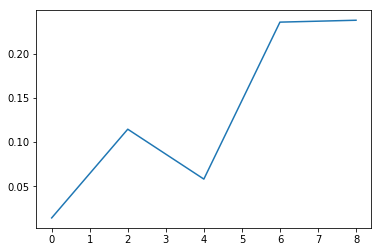

In [39]:
plt.plot(range(0,10,2), Eig_r2_test)

In [54]:
Eig_r2_test = []
for i in range(67):
    r2_train = []
    r2_test = []
    for train_idx, test_idx in ss.split(new_X1):
        X_train, y_train = new_X4[train_idx], Eig[train_idx, i]
        X_test, y_test = new_X4[test_idx], Eig[test_idx, i]

        lin_reg = ElasticNet()
        lin_reg.fit(X_train, y_train)

        r2_train += [r2_score(y_train, lin_reg.predict(X_train))]

        r2_test += [r2_score(y_test, lin_reg.predict(X_test))]

#         print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
#                                               mean_squared_error(y_test, lin_reg.predict(X_test))))

#         print('R2 train: {}, test: {}'.format(r2_train[-1], r2_test[-1]))

    print('MSE train: {}, test: {}'.format(mean_squared_error(y_train, lin_reg.predict(X_train)),
                                               mean_squared_error(y_test, lin_reg.predict(X_test))))

    print('R2 train: {}, test: {}'.format(np.mean(r2_train[-1]), np.mean(r2_test)))
    Eig_r2_test += [np.mean(r2_test)]

MSE train: 255121.640625, test: 935985.4375
R2 train: 0.7700830300104436, test: 0.02546578945337637
MSE train: 393402.6875, test: 1893735.5
R2 train: 0.7824950424583943, test: 0.05086780095802342
MSE train: 493920.46875, test: 2199514.0
R2 train: 0.7913600139273705, test: 0.11820005330648727
MSE train: 574331.8125, test: 2385239.0
R2 train: 0.7872701662231311, test: 0.0853733899428688
MSE train: 610808.875, test: 2154525.25
R2 train: 0.7914749076214984, test: 0.11270404631256659
MSE train: 614833.1875, test: 2832502.75
R2 train: 0.8109822798134492, test: 0.14907953839120347
MSE train: 692972.375, test: 3250073.5
R2 train: 0.8249362769928784, test: 0.18359693687506515
MSE train: 805600.8125, test: 3713470.0
R2 train: 0.8342669862597367, test: 0.1593878994038619
MSE train: 936108.625, test: 3707995.5
R2 train: 0.8321767179628092, test: 0.26659448172162686
MSE train: 1025229.3125, test: 3777232.25
R2 train: 0.8470697595908241, test: 0.2896936047241159
MSE train: 1098588.625, test: 4590499

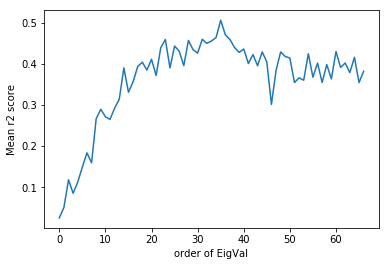

In [55]:
plt.plot(np.arange(67), Eig_r2_test)
plt.xlabel('order of EigVal')
plt.ylabel('Mean r2 score')
plt.savefig('EIG_VALS_R2')